# Programming Exercise 3 - Multi-class Classification and Neural Networks

1. [Multi-class Classification](#1-Multi-class-Classification)
    1. [Dataset](#1.1-Dataset)
    2. [Visualizing the data](#1.2-Visualizing-the-data)
    3. [Vectorizing Logistic Regression](#1.3-Vectorizing-Logistic-Regression)
        1. [Vectorizing the regularized cost function](#1.3.1-Vectorizing-the-cost-function-&&-the-regularized-cost-function)
        2. [Vectorizing the regularized gradient](#1.3.2-Vectorizing-the-gradient-&&-the-regularized-gradient)
    4. [One-vs-all Classification](#1.4-One-vs-all-Classification)
        1. [One-vs-all Prediction](#1.4.1-One-vs-all-Prediction)
    5. [Using scikit-learn](#1.5-Using-scikit-learn)
2. [Neural Networks](#2-Neural-Networks)
    1. [Model representation](#2.1-Model-representation)
    2. [Feedforward Propagation and Prediction](#2.2-Feedforward-Propagation-and-Prediction)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# MATLAB files load funtion
from scipy.io import loadmat
from scipy.special import expit as sigmoid
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression

#%config InlineBackend.figure_formats = {'pdf',}

%matplotlib inline

## 1 Multi-class Classification

### 1.1 Dataset

In [2]:
# Load saved matrices from file
data = loadmat("machine-learning-ex3/ex3/ex3data1.mat")
# The matrices X and y will now be in the data
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
X = data["X"]
y = data["y"]
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (5000, 400)
y: (5000, 1)


### 1.2 Visualizing the data

In [4]:
from math import sqrt, floor, ceil

def displayData(X, example_width=None):
    m, n = X.shape
    # Set example_width automatically if not passed in
    if not example_width:
        example_width = round(sqrt(n))
    example_height = n // example_width
    # convert to one line image containing all sample images
    X = X.reshape(-1, example_height).T
    # split line according to single image width
    img_set = np.hsplit(X, m)
    # Compute number of items to display
    display_rows = floor(sqrt(m))
    display_cols = ceil(m / display_rows)
    rows = []
    for i in range(display_cols):
        # join display_rows samples into single row
        rows.append(np.hstack(img_set[i * display_rows:(i + 1) * display_rows]))
    img = np.vstack(rows)
    # Gray Image
    plt.imshow(img, cmap="gray")
    plt.axis('off')

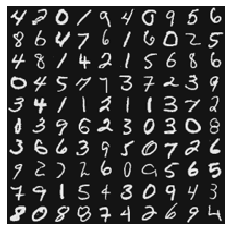

In [5]:
# Randomly selects 100 rows from X and passes 
samples = np.random.choice(y.size, 100)
displayData(X[samples], 20)


### 1.3 Vectorizing Logistic Regression

In [6]:
def h(theta, X):
    return sigmoid(X.dot(theta))

To make this training efficient, it is important to ensure that your code is well vectorized.

#### 1.3.1 Vectorizing the cost function and the regularized cost function

$$
J_{reg}(\theta) = -\frac{1}{m}\big((log(g(X\vec{\theta}))^{\mathbf{T}}\vec{y}+(log(1-g(X\vec{\theta}))^{\mathbf{T}}\vec{(1-y)}\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}
$$

In [7]:
def costFunction(theta, X, y):
    m = y.size
    h_ = h(theta, X)
    return np.asscalar(-(np.log(h_).T.dot(y) + np.log(1 - h_).T.dot(1 - y)) / m)

In [8]:
def lrCostFunction(theta, X, y, lambda_):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    cost = costFunction(theta, X, y)
    reg = lambda_ * (np.sum(np.square(theta)) - theta.item(0) ** 2) / (2 * m)
    return cost + reg

#### 1.3.2 Vectorizing the gradient and the regularized gradient

$$
\begin{equation}
\begin{split}
\frac{\partial J_{reg}(\theta)}{\partial\theta_{j}} & = \frac{1}{m}X^{\mathbf{T}}\beta + \frac{\lambda}{m}\theta_{j}& \text{ with }\ j\geq 1 \\
\beta & = g(X\vec{\theta})-\vec{y}\\
\beta_{i} & = h_{\theta}(x^{(i)})-y^{(i)}
\end{split}
\end{equation}
$$

In [9]:
def gradient(theta, X, y):
    m = y.size
    h_ = h(theta, X)
    beta = h_ - y
    return X.T.dot(beta) / m

In [10]:
def lrGradient(theta, X, y, lambda_):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    grad = gradient(theta, X, y)
    reg = lambda_ * theta / m
    # dont regularize first term
    reg[0][0] = 0
    assert grad.shape == reg.shape
    return (grad + reg).flatten()

### 1.4 One-vs-all Classification

In [11]:
# trains multiple regularized logistic regression classifiers
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    initial_theta = np.zeros(n)
    big_theta = np.empty((num_labels, n))
    # class labels belong to {1,...k}
    for label in range(1, num_labels + 1):
        # trains each classifier independently and fill each row of big theta
        # return a vector of the same size as a with 
        # ones at positions where the elements of a are equal to b
        # and zeros where they are different
        oneVsAll_y = (y == label).astype("int8")
        # you will be using fmincg for this exercise (instead of general minimize function)
        # it is more more efficient for dealing with a large number of parameters
        res = minimize(lrCostFunction, initial_theta, args=(X, oneVsAll_y, lambda_), method=None, jac=lrGradient, options={
            "maxiter": 50
        })
        big_theta[label - 1] = res.x
    return big_theta

In [12]:
X_with_Ones = np.column_stack((np.ones((y.size, 1)), X))
big_theta = oneVsAll(X_with_Ones, y, 10, 0.1)

#### 1.4.1 One-vs-all Prediction

In [13]:
def predictOneVsAll(X, big_theta):
    # For each input, compute the "probabilitu" that it belongs
    # to each class using the trained logistic regression clssifiers
    probs = sigmoid(X_with_Ones.dot(big_theta.T))
    # outputs the highest probability and corresponding logistic regression
    return np.argmax(probs, axis=1) + 1

In [14]:
predicted_y = predictOneVsAll(X_with_Ones, big_theta).reshape((-1, 1))
# You should see that the training set accuracy is about 94.9%
np.mean(predicted_y == y) * 100

93.24

#### 1.5 Using scikit-learn

In [15]:
clf = LogisticRegression(C=10)
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X, y.ravel())

/home/dalao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dalao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
pred2 = clf.predict(X)
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel()) * 100))

Training set accuracy: 96.5 %


## 2 Neural Networks

### 2.1 Model representation

In [17]:
# Load saved matrices from file
weights = loadmat('./machine-learning-ex3/ex3/ex3weights.mat')
# The matrices Theta1 and Theta2 will now be in weights
print(weights.keys())
Theta1 = weights["Theta1"]
Theta2 = weights["Theta2"]
# Theta1 has size 25 x 401
print(Theta1.shape)
# Theta2 has size 10 x 26
print(Theta2.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
(25, 401)
(10, 26)


![NeuralNetworkModel](NeuralNetworkModel.png)

### 2.2 Feedforward Propagation and Prediction

In [18]:
def predict(Theta1, Theta2, X):
    # PREDICT Predict the label of an input given a trained neural network
    #Input Layer
    a1 = X
    # Hidden Layer
    m, n = a1.shape
    z2 = np.column_stack((np.ones((m, 1)), a1)).dot(Theta1.T)
    a2 = sigmoid(z2)
    # Output Layer
    m, n = a2.shape
    z3 = np.column_stack((np.ones((m, 1)), a2)).dot(Theta2.T)
    a3 = sigmoid(z3)

    return (np.argmax(a3, axis=1) + 1)

In [19]:
p = predict(Theta1, Theta2, X)
# You should see that the accuracy is about 97.5%
print('Training set accuracy: {} %'.format(np.mean(p == y.ravel()) * 100))

Training set accuracy: 97.52 %
